In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
from tensorflow import keras

In [2]:
# set the random seed:
RANDOM_SEED = 77
random.seed(RANDOM_SEED)

# Read Data Set

In [3]:
df = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv")
df['EncodedPixels'] = df['EncodedPixels'].astype('string')

# Delete corrupted images
corrupted_images = ['6384c3e78.jpg']
df = df.drop(df[df['ImageId'].isin(corrupted_images)].index)

# Dataframe that contains the segmentation for each ship in the image. 
instance_segmentation = df

# Dataframe that contains the segmentation of all ships in the image.
image_segmentation = df.groupby(by=['ImageId'])['EncodedPixels'].apply(lambda x: np.nan if pd.isna(x).any() else ' '.join(x)).reset_index()

# Utils

In [4]:
def rle_to_mask(rle: str, shape=(768, 768)):
    '''
    :param rle: run length encoded pixels as string formated
           shape: (height,width) of array to return 
    :return: numpy 2D array, 1 - mask, 0 - background
    '''
    encoded_pixels = np.array(rle.split(), dtype=int)
    starts = encoded_pixels[::2] - 1
    ends = starts + encoded_pixels[1::2]
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def mask_to_rle(img, shape=(768, 768)) -> str:
    """
    :param img: numpy 2D array, 1 - mask, 0 - background
           shape: (height,width) dimensions of the image 
    :return: run length encoded pixels as string formated
    """
    img = cv2.resize(img, shape, interpolation=cv2.INTER_AREA)
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Data preprocessing

In [5]:
TRAIN_LENGTH = image_segmentation.shape[0]
BATCH_SIZE = 32
BUFFER_SIZE = 100
IMG_SHAPE = (128, 128)
TRAIN_DIR = '/kaggle/input/airbus-ship-detection/train_v2/'
TEST_DIR = '/kaggle/input/airbus-ship-detection/test_v2/'

2022-08-19 16:47:54.147519: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-08-19 16:49:09.753745: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Image shape:  (1, 128, 128, 3)
Label:  (1, 128, 128, 1)
Image shape:  (1, 128, 128, 3)
Label:  (1, 128, 128, 1)
Image shape:  (1, 128, 128, 3)
Label:  (1, 128, 128, 1)
Image shape:  (1, 128, 128, 3)
Label:  (1, 128, 128, 1)
Image shape:  (1, 128, 128, 3)
Label:  (1, 128, 128, 1)
Image shape:  (1, 128, 128, 3)
Label:  (1, 128, 128, 1)
Image shape:  (1, 128, 128, 3)
Label:  (1, 128, 128, 1)
Image shape:  (1, 128, 128, 3)
Label:  (1, 128, 128, 1)
Image shape:  (1, 128, 128, 3)
Label:  (1, 128, 128, 1)
Image shape:  (1, 128, 128, 3)
Label:  (1, 128, 128, 1)


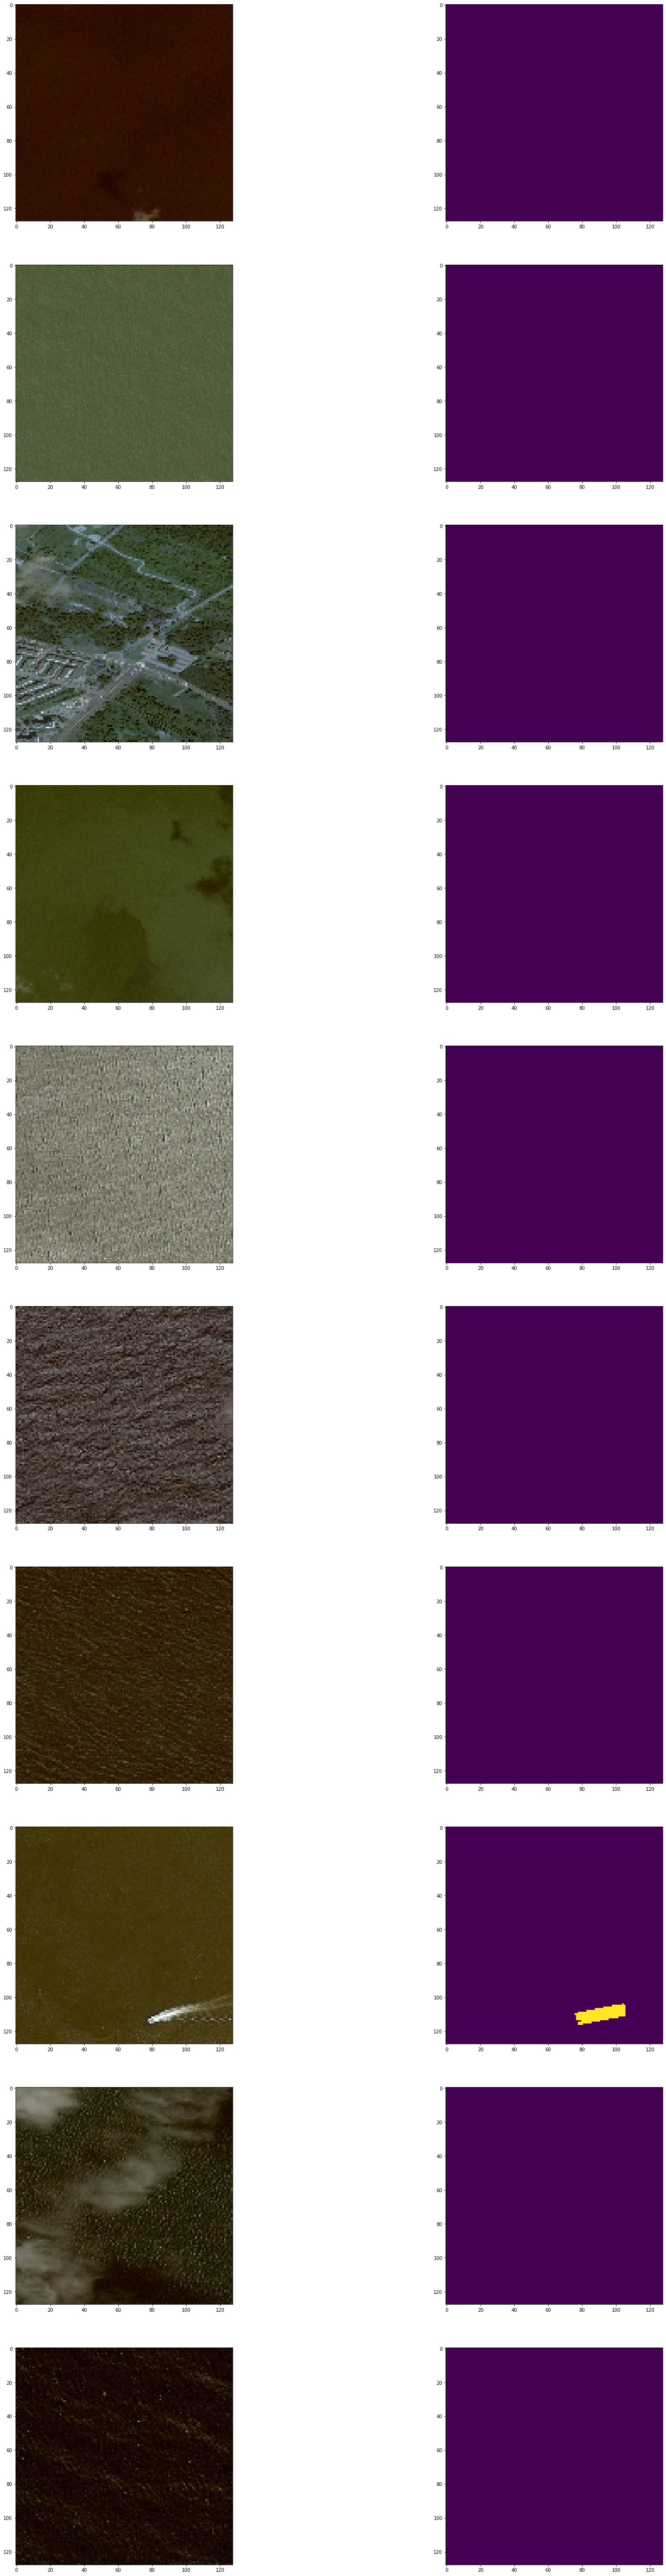

In [6]:
def load_train_image(tensor) -> tuple:
    path = tf.get_static_value(tensor).decode("utf-8")

    image_id = path.split('/')[-1]
    input_image = cv2.imread(path)
    input_image = tf.image.resize(input_image, IMG_SHAPE)
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image = np.expand_dims(input_image, axis=0)

    encoded_mask = image_segmentation[image_segmentation['ImageId'] == image_id].iloc[0]['EncodedPixels']
    input_mask = np.zeros((1,) + IMG_SHAPE + (1,))
    if not pd.isna(encoded_mask):
        input_mask = rle_to_mask(encoded_mask)
        input_mask = cv2.resize(input_mask, IMG_SHAPE, interpolation=cv2.INTER_AREA)
        input_mask = np.expand_dims(input_mask, axis=(0,3))

    return input_image, input_mask

images_list = tf.data.Dataset.list_files(f'{TRAIN_DIR}*')
train_images = images_list.map(lambda x: tf.py_function(load_train_image, [x], [tf.float32, tf.float32]), num_parallel_calls=tf.data.AUTOTUNE)

f,ax = plt.subplots(10, 2, figsize=(30, 100))
i = 0
for image, label in train_images.take(10):
    print('==========')
    print("Image shape: ", image.shape)
    print("Label: ", label.shape)
    ax[i, 0].imshow(image[0])
    ax[i, 1].imshow(label[0])
    i += 1
    
plt.show()

train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

# UNet segmentation model

In [7]:
import keras.backend as K

class UNetModel:
    def __init__(self, input_shape=(128, 128, 3)):
        self._model = self._build_model(input_shape)

    @property
    def model(self) -> tf.keras.Model:
        return self._model
    
    def _build_model(self, input_shape) -> tf.keras.Model:
        inputs = tf.keras.layers.Input(shape=input_shape)

        # apply Encoder
        skips = self._encoder(input_shape)(inputs)
        x = skips[-1]
        skips = reversed(skips[:-1])

        # apply Decoder and establishing the skip connections
        x = self._decoder(skips, x)

        # This is the last layers of the model
        last = tf.keras.layers.Conv2DTranspose(
          filters=20, kernel_size=3, strides=2, padding='same')  # 64x64 -> 128x128
        x = last(x)
        outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

        return tf.keras.Model(inputs=inputs, outputs=outputs)
    
    def _encoder(self, input_shape):
        base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)

        # Use the activations of these layers
        layer_names = [
            'block_1_expand_relu',   # 64x64
            'block_3_expand_relu',   # 32x32
            'block_6_expand_relu',   # 16x16
            'block_13_expand_relu',  # 8x8
            'block_16_project',      # 4x4
        ]
        base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

        # Create the feature extraction model
        encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
        encoder.trainable = True
        return encoder
    
    def _decoder(self, skips, encoder_output):
        decoder_stack = [
            self._upsample_block(512, 3),  # 4x4 -> 8x8
            self._upsample_block(256, 1),  # 8x8 -> 16x16
            self._upsample_block(128, 3),  # 16x16 -> 32x32
            self._upsample_block(64, 1),   # 32x32 -> 64x64
        ]
        
        x = encoder_output
        for block, skip in zip(decoder_stack, skips):
            x = block(x)
            concat = tf.keras.layers.Concatenate()
            x = concat([x, skip])
        
        return x
    
    def _upsample_block(self, filters, size, apply_dropout=False):
        """Upsamples an input. Conv2DTranspose => Batchnorm => Dropout => Relu
            :param:
                filters: number of filters
                size: filter size
                apply_dropout: If True, adds the dropout layer
            :return: Upsample Sequential Model
        """
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(
          tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          use_bias=False))
        result.add(tf.keras.layers.BatchNormalization())
        if apply_dropout:
            result.add(tf.keras.layers.Dropout(0.5))
        result.add(tf.keras.layers.ReLU())
        return result
    

def dice_loss(targets, inputs, smooth=1e-6):
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(K.dot(targets, inputs))
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

# Intersection over Union for Objects
def IoU(y_true, y_pred, tresh=1e-10):
    Intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    Union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - Intersection
    return K.mean( (Intersection + tresh) / (Union + tresh), axis=0)

def IoU_loss(in_gt, in_pred):
    #return 2 - back_IoU(in_gt, in_pred) - IoU(in_gt, in_pred)
    return 1 - IoU(in_gt, in_pred)

9420800/9406464 [==============================] - 0s 0us/step


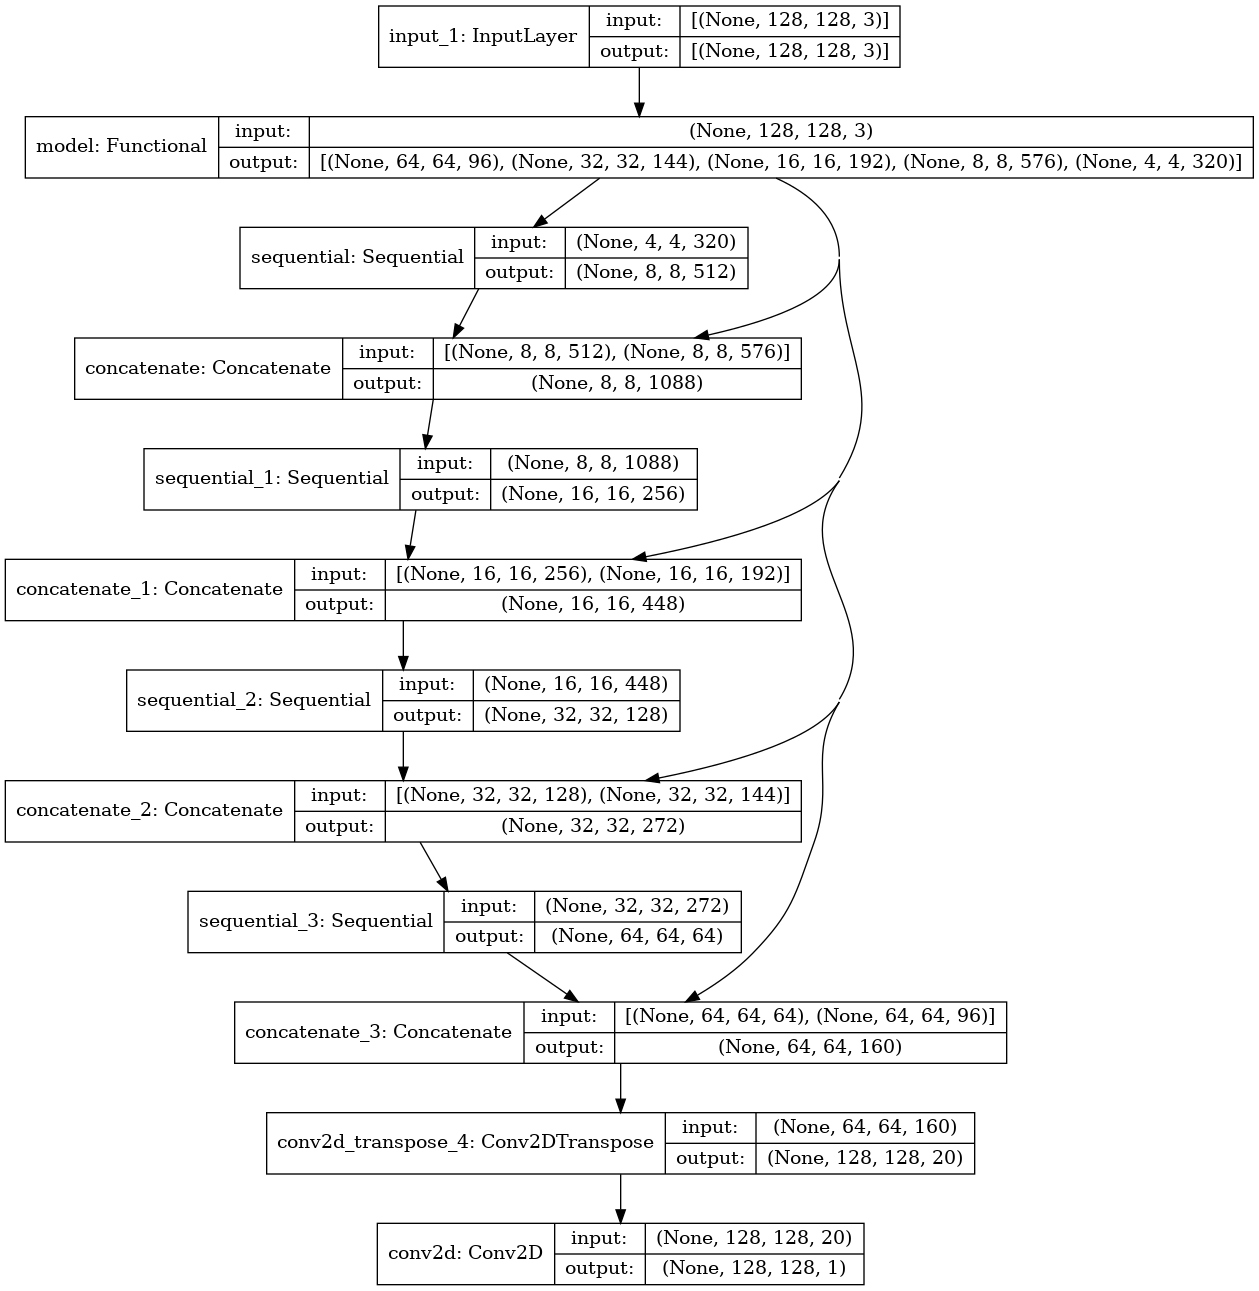

In [8]:
model = UNetModel(IMG_SHAPE + (3,)).model
model.compile(optimizer='adam', 
              loss=IoU_loss,
              metrics=[])
tf.keras.utils.plot_model(model, show_shapes=True)

In [9]:
EPOCHS = 5
STEPS_PER_EPOCH = 100

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,)


Epoch 1/5
100/100 [==============================] - 217s 2s/step - loss: 1.0080
Epoch 2/5
100/100 [==============================] - 204s 2s/step - loss: 1.1118
Epoch 3/5
100/100 [==============================] - 206s 2s/step - loss: 1.1567
Epoch 4/5
100/100 [==============================] - 206s 2s/step - loss: 0.9539
Epoch 5/5
100/100 [==============================] - 206s 2s/step - loss: 0.9054


2022-08-19 17:06:37.408641: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Images shape:  (128, 128, 3)
Pred Label:  (32, 128, 128, 1)


2022-08-19 17:12:25.694112: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


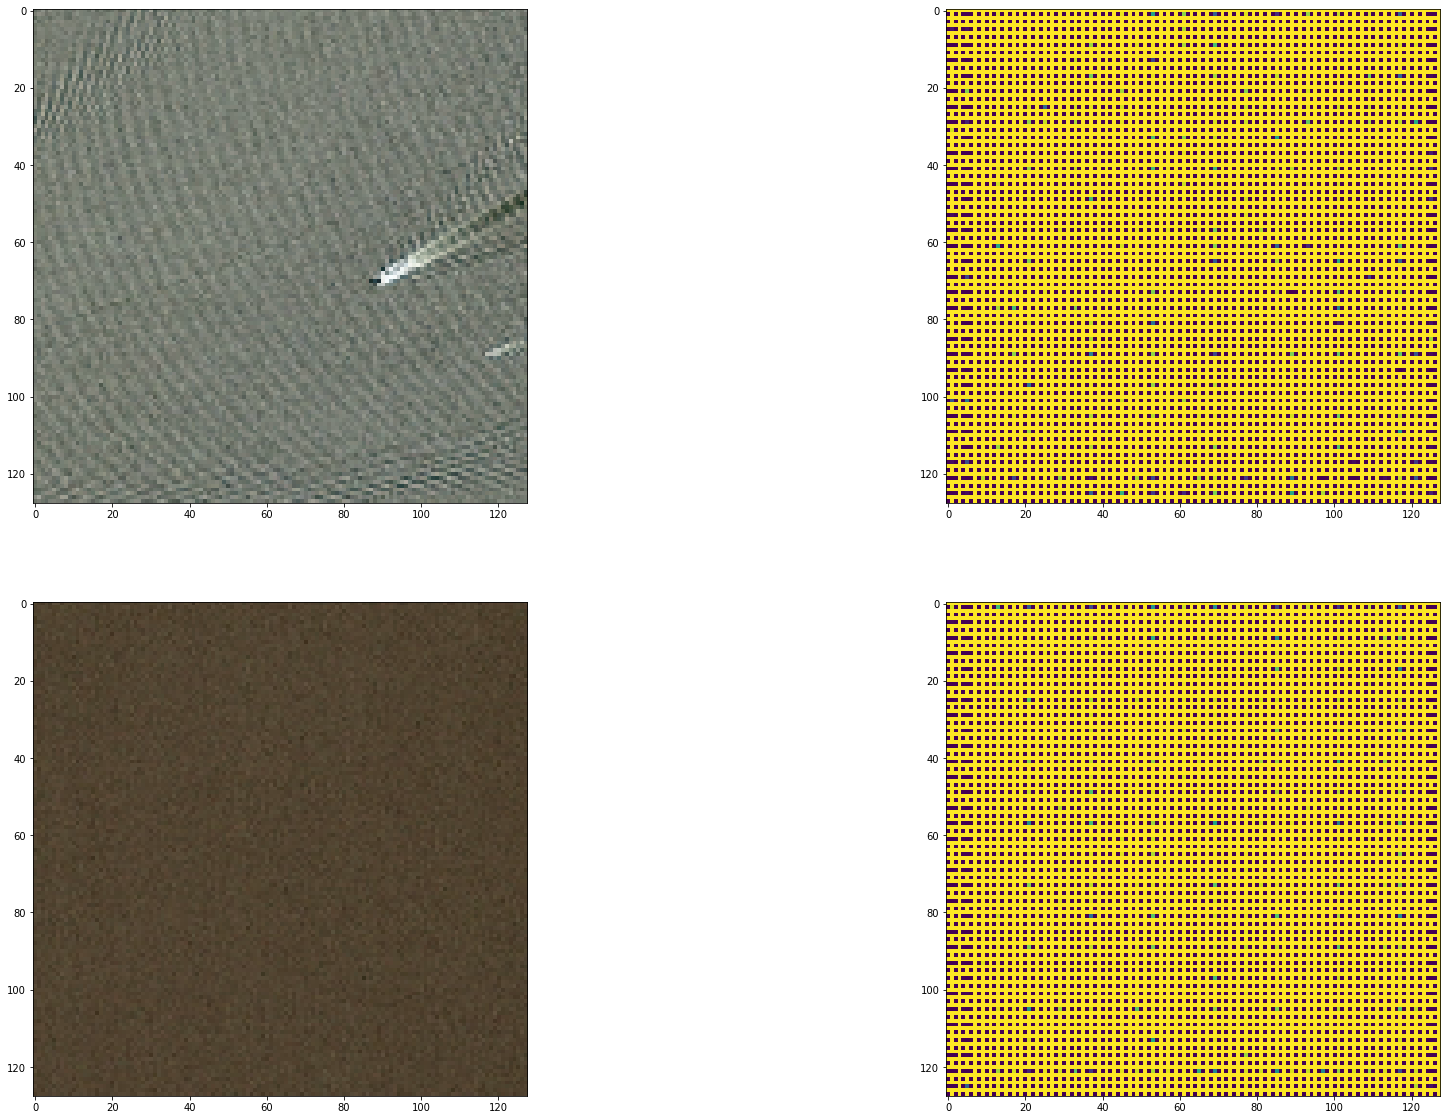

In [13]:
def load_test_image(tensor):
    path = tf.get_static_value(tensor).decode("utf-8")
    image_id = path.split('/')[-1]
    input_image = cv2.imread(path)
    input_image = tf.image.resize(input_image, IMG_SHAPE)
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

test_images_list = tf.data.Dataset.list_files(f'{TEST_DIR}*')
test_images = test_images_list.map(lambda x: tf.py_function(load_test_image, [x], [tf.float32]), num_parallel_calls=tf.data.AUTOTUNE)
test_batches = (
    test_images
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE))


f,ax = plt.subplots(2, 2, figsize=(30, 20))
i = 0
for images in test_batches.take(1):
    image = images[0][0]
    print('==========')
    print("Images shape: ", image.shape)
    ax[i, 0].imshow(image)

    pred_mask = model.predict(images)
    print("Pred Label: ", pred_mask.shape)
    ax[i, 1].imshow(pred_mask[0])
    i += 1
    ax[i, 0].imshow(images[0][1])
    ax[i, 1].imshow(pred_mask[1])


plt.show()